# First example

## Introduction

In this first example, we will run the PSF subtraction on a preprocessed ADI dataset of $\beta$ Pictoris. This archival dataset was obtained with NACO in $M'$ (4.8 $\mu$m) at the Very Large Telescope (ESO program ID: [090.C-0653(D)](http://archive.eso.org/wdb/wdb/eso/sched_rep_arc/query?progid=090.C-0653(D))). The exposure time per image was 65 ms and the parallactic rotation was about 50 degrees. Every 200 images have been mean-collapsed to limit the size of the dataset.

## Getting started

We start by importing the required Python modules for this tutorial.

In [1]:
import os
import urllib
import matplotlib.pyplot as plt

And also the pipeline and pipeline modules of PynPoint.

In [2]:
from pynpoint import Pypeline, Hdf5ReadingModule, PSFpreparationModule, PcaPsfSubtractionModule

Next, we download the preprocessed data (13 MB). The dataset is stored in an HDF5 database and contains 263 images of 80 by 80 pixels. The parallactic angles and pixel scale are stored as attributes of the dataset.

In [3]:
urllib.request.urlretrieve('https://home.strw.leidenuniv.nl/~stolker/pynpoint/betapic_naco_mp.hdf5',
                           './betapic_naco_mp.hdf5')

('./betapic_naco_mp.hdf5', <http.client.HTTPMessage at 0x14120ce10>)

## Initiating the Pypeline

We will now initiate PynPoint by creating an instance of the [Pypeline](https://pynpoint.readthedocs.io/en/latest/pynpoint.core.html?highlight=Pypeline#pynpoint.core.pypeline.Pypeline) class. The object requires the paths of the working folder, input folder and output folder. Here we simply use the current folder for all three of them.

In [4]:
pipeline = Pypeline(working_place_in='./',
                    input_place_in='./',
                    output_place_in='./')

PynPoint v0.9.0

Working folder: ./
Input folder: ./
Output folder: ./

Database: ./PynPoint_database.hdf5
Configuration: ./PynPoint_config.ini

Number of CPUs: 8
Number of threads: not set


/Users/tomasstolker/applications/pynpoint/pynpoint/core/pypeline.py:286: UserWarning: Configuration file not found. Creating PynPoint_config.ini with default values in the working place.
  warnings.warn('Configuration file not found. Creating PynPoint_config.ini with '


A configuration file with default values has been created in the working folder. Next, we will add three pipeline modules to the `Pypeline` object.

## PSF subtraction with PCA

We start with the [Hdf5ReadingModule](https://pynpoint.readthedocs.io/en/latest/pynpoint.readwrite.html#pynpoint.readwrite.hdf5reading.Hdf5ReadingModule) which will import the preprocessed data from the HDF5 file that was downloaded into the current database. The instance of the `Hdf5ReadingModule` class is added to the `Pypeline` with the [add_module](https://pynpoint.readthedocs.io/en/latest/pynpoint.core.html?highlight=add_module#pynpoint.core.pypeline.Pypeline.add_module) method. The dataset that we need to import has the tag *stack* so we specify this name as input and output in the dictionary of `tag_dictionary`.

In [5]:
module = Hdf5ReadingModule(name_in='read',
                           input_filename='betapic_naco_mp.hdf5',
                           input_dir=None,
                           tag_dictionary={'stack': 'stack'})

pipeline.add_module(module)

Next, we ise the [PSFpreparationModule](https://pynpoint.readthedocs.io/en/latest/pynpoint.processing.html?highlight=psfprep#pynpoint.processing.psfpreparation.PSFpreparationModule) to mask the central (saturated) area of the PSF and also pixels beyond 1.1 arcseconds.

In [6]:
module = PSFpreparationModule(name_in='prep',
                              image_in_tag='stack',
                              image_out_tag='prep',
                              mask_out_tag=None,
                              norm=False,
                              resize=None,
                              cent_size=0.15,
                              edge_size=1.1)

pipeline.add_module(module)

The last pipeline module that we use is [PcaPsfSubtractionModule](https://pynpoint.readthedocs.io/en/latest/pynpoint.processing.html?highlight=pcapsf#pynpoint.processing.psfsubtraction.PcaPsfSubtractionModule). This module will run the PSF subtraction with PCA. Here we chose to subtract 20 principal components and store the median-collapsed residuals at the database tag *residuals*.

In [7]:
module = PcaPsfSubtractionModule(pca_numbers=[20, ],
                                 name_in='pca',
                                 images_in_tag='prep',
                                 reference_in_tag='prep',
                                 res_median_tag='residuals')

pipeline.add_module(module)

We can now run the three pipeline modules that were added toe the `Pypeline` with the [run](https://pynpoint.readthedocs.io/en/latest/pynpoint.core.html?highlight=Pypeline#pynpoint.core.pypeline.Pypeline.run) method.

In [8]:
pipeline.run()


-----------------
Hdf5ReadingModule
-----------------

Module name: read
Reading HDF5 file... [DONE]                      
Output port: stack (263, 80, 80)

--------------------
PSFpreparationModule
--------------------

Module name: prep
Input port: stack (263, 80, 80)
Preparing images for PSF subtraction... [DONE]                      
Output port: prep (263, 80, 80)

-----------------------
PcaPsfSubtractionModule
-----------------------

Module name: pca
Input port: prep (263, 80, 80)
Input parameters:
   - Post-processing type: ADI
   - Number of principal components: [20]
   - Subtract mean: True
   - Extra rotation (deg): 0.0
Constructing PSF model... [DONE]
Creating residuals. [DONE]
Output port: residuals (1, 80, 80)


## Accessing results in the database

The `Pypeline` has [several methods](https://pynpoint.readthedocs.io/en/latest/pynpoint.core.html?highlight=Pypeline#pynpoint.core.pypeline.Pypeline) to access the datasets and attributes that are stored in the database. For example, we can use the [get_shape](https://pynpoint.readthedocs.io/en/latest/pynpoint.core.html?highlight=Pypeline#pynpoint.core.dataio.InputPort.get_shape) method to check the shape of the *residuals* dataset that was stored by the `PcaPsfSubtractionModule`. The dataset contains 1 image since we ran the PSF subtraction only with 20 principal components.

In [9]:
pipeline.get_shape('residuals')

(1, 80, 80)

Next, we use the [get_data](https://pynpoint.readthedocs.io/en/latest/pynpoint.core.html?highlight=Pypeline#pynpoint.core.pypeline.Pypeline.get_data) method to read the median-collapsed residuals of the PSF subtraction.

In [10]:
residuals = pipeline.get_data('residuals')

We will also extract the pixel scale, which is stored as the `PIXSCALE` attribute of the dataset, by using the [get_attribute](https://pynpoint.readthedocs.io/en/latest/pynpoint.core.html?highlight=Pypeline#pynpoint.core.pypeline.Pypeline.get_attribute) method.

In [11]:
pixscale = pipeline.get_attribute('residuals', 'PIXSCALE')
print(f'Pixel scale = {pixscale*1e3} mas')

Pixel scale = 27.0 mas


## Plotting the residuals

Finally, let's have a look at the residuals of the PSF subtraction. For simplicity, we define the image size in arcseconds.

In [12]:
size = pixscale * residuals.shape[-1]/2.

And plot the first image of the *residuals* dataset with `matplotlib`.

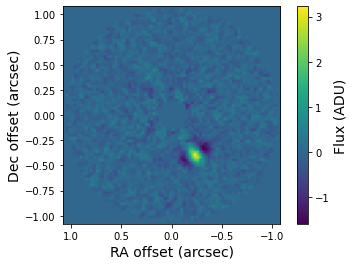

In [13]:
plt.imshow(residuals[0, ], origin='lower', extent=[size, -size, -size, size])
plt.xlabel('RA offset (arcsec)', fontsize=14)
plt.ylabel('Dec offset (arcsec)', fontsize=14)
cb = plt.colorbar()
cb.set_label('Flux (ADU)', size=14.)

The star is located in the center of the image (which is masked here) and the orientation of the image is such that north is up and east is left. The bright yellow feature in southwest direction is the exoplanet $\beta$ Pictoris b at an angular separation of 0.46 arcseconds.